In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
device = "cpu"

import yaml
import os
cfg_path = "checkpoints/thesis/config.yaml"

with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

cfg["device"] = device
cfg["model"]["patchify_args"]["device"] = device
cfg["model"]["unpatchify_args"]["device"] = device

from src.utils import load_model_from_config

model = load_model_from_config(cfg)

# Find and load last epoch in the directory
dir = os.path.join(cfg["training"]["checkpoint_dir"], "model")
last_epoch = max([int(f.split("_")[1].removesuffix(".pth")) for f in os.listdir(dir) if f.startswith("epoch_")], default=0)
model.load_model(os.path.join(dir, f"epoch_{last_epoch}.pth"))

model.eval()

ALMTokenizer(
  (query_encoder): QueryEncoder(
    (layers): ModuleList(
      (0-11): 12 x RopeEncoderLayer(
        (q_proj): Linear(in_features=128, out_features=128, bias=False)
        (k_proj): Linear(in_features=128, out_features=128, bias=False)
        (v_proj): Linear(in_features=128, out_features=128, bias=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
        (rope): RotaryPositionalEmbeddings()
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=256, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (query_decoder): QueryEncoder(
    (layers): ModuleList(
      (0-11): 12 x RopeEncoderLayer(
        (q_proj): Linear(in_features=128, out_features=128, bias=False)
        (k_proj

### Generate the embeddings

In [4]:
from src.datasets import GoodSoundsDataset



dataset = GoodSoundsDataset(root_dir="../good_sounds_dataset",
                            db_filename="good-sounds/database.sqlite")

from utils import save_codes_h5

save_codes_h5(
    dataset=dataset,
    model=model.eval(),
    h5_path="codes/good_sounds2.h5",
    device=device
)

100%|██████████| 16308/16308 [08:21<00:00, 32.53it/s] 

Saved codes and metadata for 16308 samples to codes/good_sounds2.h5


### Structure the data

In [ ]:
import h5py
from tqdm import tqdm
import torch

z = list()
z_attrs = list()

h = list()
h_attrs = list()

with h5py.File("codes/good_sounds2.h5", 'r') as f:
    # Get the mean of each sample's codes
    for i, key in tqdm(enumerate(f.keys())):
        grp = f[key]

        keys = ["sound_id", "instrument", "note", "octave", "klass"]
        res_dict = dict()
        for key in keys:
            res_dict[key] = grp.attrs.get(key, "unknown")
        try:
            z_mat = grp["z_level_0"][:].T
            if z_mat.ndim == 1:
                z_mat = z_mat[torch.newaxis, :]
            z_attrs += [res_dict] * z_mat.shape[0]
            z.append(z_mat)

            h_mat = grp["h_level_0"][:]
            if h_mat.ndim == 1:
                h_mat = h_mat[torch.newaxis, :]
            h_attrs += [res_dict] * h_mat.shape[0]
            h.append(h_mat)
        except Exception as e:
            print(f"Error processing group {key}: {e}")

2705it [00:01, 1508.10it/s]


In [ ]:
import numpy as np
z_res = np.vstack(z)
h_res = np.vstack(h)

In [ ]:
import gc
del z
del h
gc.collect()

20

In [3]:
import pandas as pd

z_attributes = pd.DataFrame(z_attrs)
h_attributes = pd.DataFrame(h_attrs)
X = pd.concat([pd.DataFrame(z_res), pd.DataFrame(h_res)], keys=["EnCodec", "ALMTokenizer"])
df = pd.concat([z_attributes, h_attributes], keys=["EnCodec", "ALMTokenizer"])

NameError: name 'z_attrs' is not defined

### Define the labels

In [ ]:
# Transform labels to integer indices
from sklearn.preprocessing import LabelEncoder

def generate_label_encoder(df, keys):
    encoders = dict()
    num_labels = df.copy()
    for key in keys:
        le = LabelEncoder()
        le.fit(df[key])
        encoders[key] = le
        num_labels[key] = le.transform(df[key])
    return encoders, num_labels

def get_good_bad(label: str) -> str:
    if not label or label.strip() == "":
        return "other"
    if "good" in label:
        return "good"
    if "bad" in label:
        return "bad"
    return "other"

df["klass"] = df["klass"].apply(get_good_bad)
attributes = ["instrument", "note", "octave", "klass"]
label_encoders, num_labels = generate_label_encoder(df, attributes)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def stratified_sample(df, source_col="source", n=100, group_cols=("instrument", "note", "octave", "klass"), random_state=0):
    df = df.copy()
    # Create a combined label for stratification
    
    sample_indices = []
    for src, d in df.groupby(level=0):
        strata = d[list(group_cols)].astype(str).agg("_".join, axis=1)
        # If not enough rows, just take all
        n_target = min(n, len(d))
        if n_target == len(d):
            sample_indices += d
        else:
            # Stratified downsample
            s, _ = train_test_split(
                d, train_size=n_target, 
                stratify=strata, 
                random_state=random_state
            )
            sample_indices += s.index.tolist()

    return sample_indices

In [ ]:
indices = stratified_sample(
    df, 
    source_col="source",
    n=10000,
    group_cols=("instrument", "note"),
    random_state=123
)


In [2]:
df_subset = df.loc[indices]
x_subset = X.loc[indices]
num_labels_subset = num_labels.loc[indices]

NameError: name 'df' is not defined

In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt
from matplotlib import cm

def projection(x, labels_df, columns, proj_fn=TSNE, y=None, legend=True, proj_fn_kwargs={}, transform_kwargs={}, plot_kwargs={}):

    proj = proj_fn(**proj_fn_kwargs)
    
    
    if y is None:
        coords = proj.fit_transform(x, **transform_kwargs)

    fig, axs = plt.subplots(1, len(columns), figsize=(20, 5))
    try:
        axs = axs.flatten()
    except AttributeError:
        axs = [axs]

    labels = labels_df
    for ax, key in zip(axs, columns):
        if y is not None:
            y_grp = y[key]
            coords = proj.fit_transform(x, y_grp, **transform_kwargs)
        colors = cm.get_cmap("tab10", len(labels_df[key].unique()))
        for label, c in zip(labels_df[key].unique(), colors.colors.tolist()):
            # Get coordinates for the current label
            grp_coords = coords[labels[key] == label]
            ax.scatter(grp_coords[:, 0], grp_coords[:, 1], color=c, s=1.5, cmap="tab10", label=label)
        ax.set_title(key)
        xlabel = plot_kwargs.get("xlabel", "Axis 1")
        ax.set_xlabel(xlabel)

        ylabel = plot_kwargs.get("ylabel", "Axis 2")
        ax.set_ylabel(ylabel)

        if legend:
            ax.legend(loc='upper right', fontsize='small', markerscale=2, ncol=2)
        ax.set_aspect("equal")

    if "suptitles" in plot_kwargs:
        suptitle = plot_kwargs["suptitles"]
        fig.suptitle(suptitle, fontsize=16, y=1.1)
    return fig



In [1]:
from sklearn.decomposition import PCA

plot_kwargs = {
    "xlabel": "PCA 1",
    "ylabel": "PCA 2",
}

attributes = ["instrument", "note", "octave", "klass"]

for method in x_subset.index.levels[0]:
    plot_kwargs["suptitles"] = f"{method}"
    x_grp = x_subset.loc[method]
    df_grp = df_subset.loc[method]
    fig = projection(x_grp, df_grp, attributes, PCA, plot_kwargs=plot_kwargs)
    fig.savefig(f"figs/{method}_pca.png", dpi=300)

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NameError: name 'x_subset' is not defined

/tmp/ipykernel_332271/1401697192.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


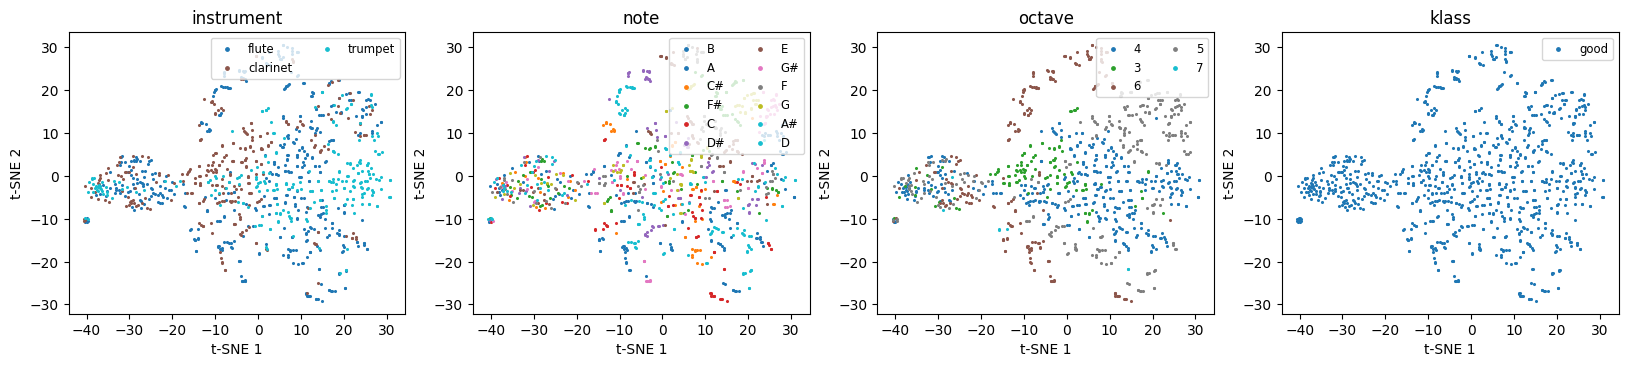

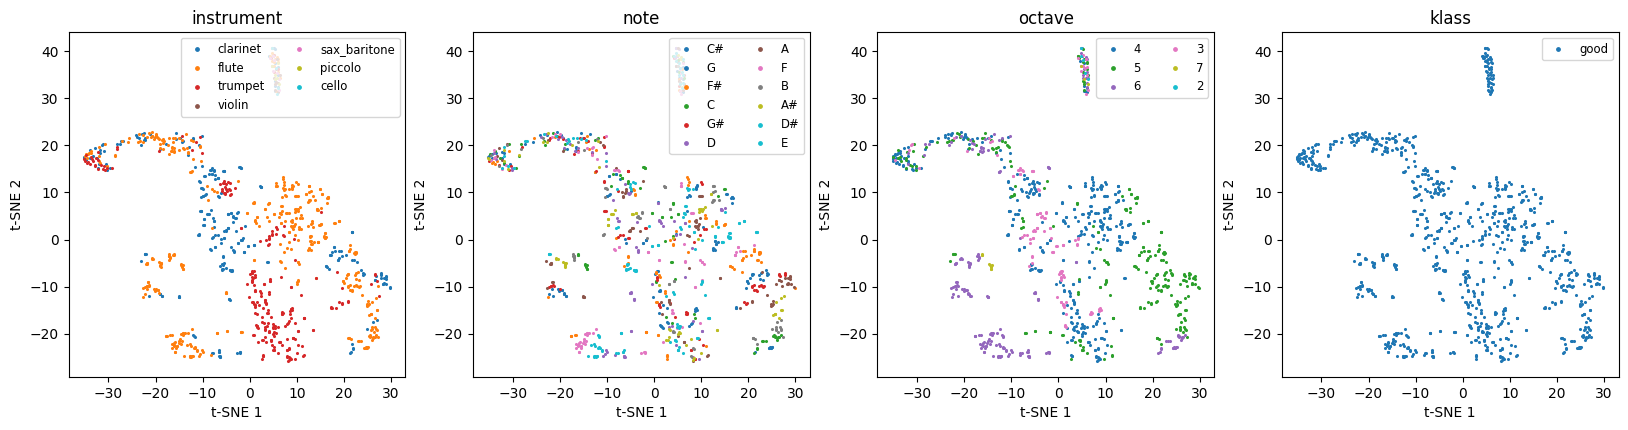

In [ ]:
plot_kwargs = {
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
}

for method in x_subset.index.levels[0]:
    x_grp = x_subset.loc[method]
    df_grp = df_subset.loc[method]
    fig = projection(x_grp, df_grp, attributes, TSNE, proj_fn_kwargs={'n_jobs': -1}, plot_kwargs=plot_kwargs)
    fig.savefig(f"figs/{method}_tsne.png", dpi=300)

/tmp/ipykernel_350380/3247569012.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_350380/3247569012.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


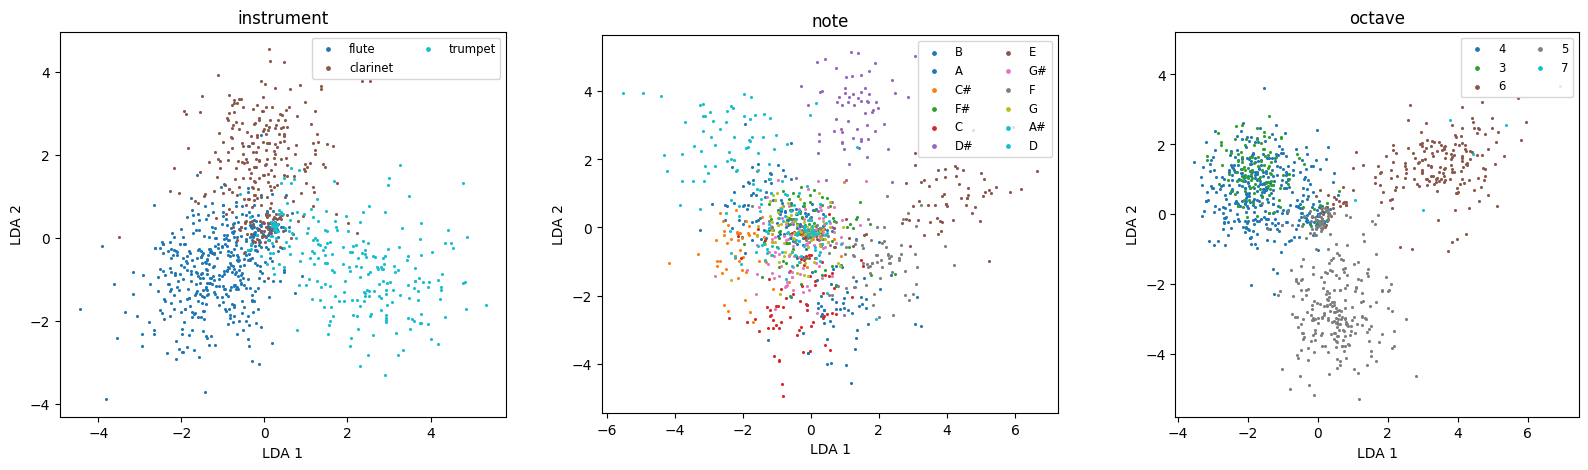

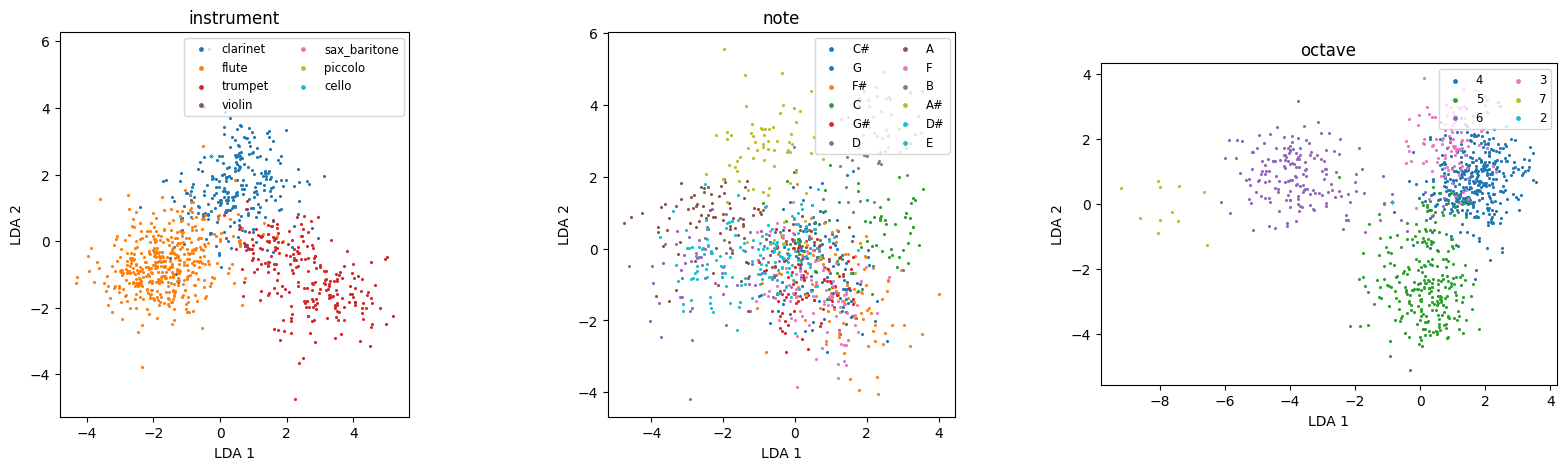

In [ ]:
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

plot_kwargs = {
    "xlabel": "LDA 1",
    "ylabel": "LDA 2",
}

for method in x_subset.index.levels[0]:
    x_grp = x_subset.loc[method]
    df_grp = df_subset.loc[method]
    projection(x_grp, df_grp, attributes[:-1], LDA, y=df_grp[attributes[:-1]], plot_kwargs=plot_kwargs)


# Clustering

100%|██████████| 17/17 [00:16<00:00,  1.00it/s]
/tmp/ipykernel_332271/894445274.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_332271/3247569012.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
100%|██████████| 17/17 [00:16<00:00,  1.05it/s]
/tmp/ipykernel_332271/894445274.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_332271/3247569012.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


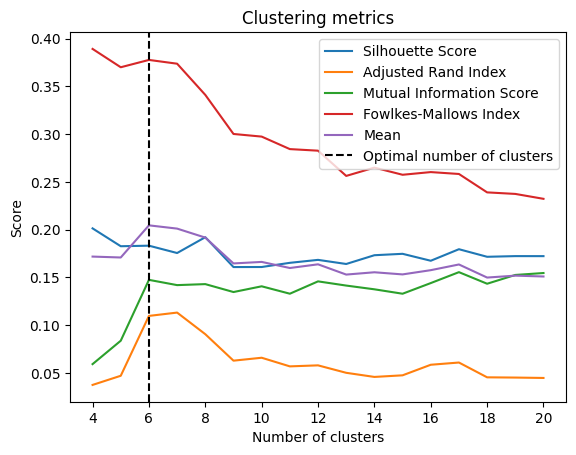

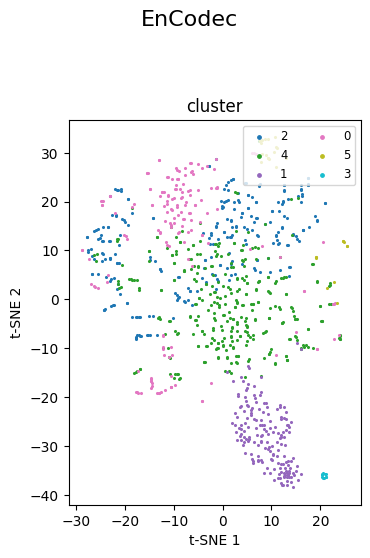

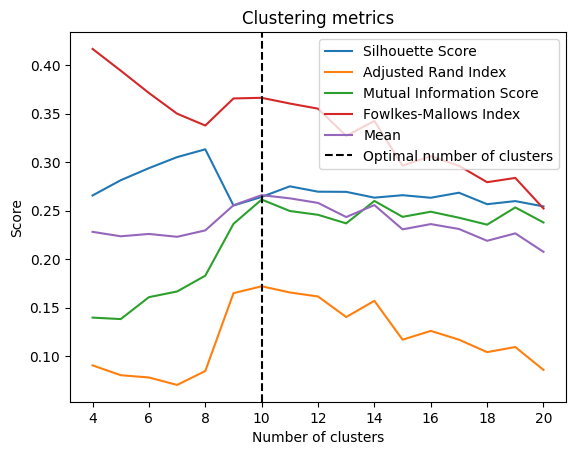

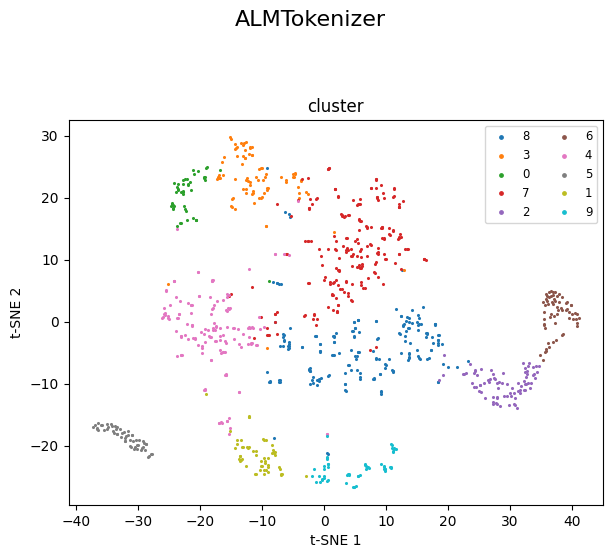

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score
from matplotlib.ticker import MaxNLocator

def scan_k(x, true_labels, k_range):

    # Initialize lists to store metrics
    rands = list()
    mis = list()
    fmis = list()
    sil = list()
    bics = list()
    aics = list()
    ks = list()

    for k in k_range:
        kmean = KMeans(n_clusters=k)
        clusters = kmean.fit_predict(x)

        # Compute clustering metrics
        sil.append(silhouette_score(x, clusters))
        rands.append(adjusted_rand_score(true_labels, clusters))
        mis.append(normalized_mutual_info_score(true_labels, clusters))
        fmis.append(fowlkes_mallows_score(true_labels, clusters))
        ks.append(k)

    # Create a figure and axis
    fig, axs = plt.subplots(1, 1)

    # Plot the Silhouette Score
    axs.plot(ks, sil, label="Silhouette Score")

    # Plot the Adjusted Rand Index
    axs.plot(ks, rands, label="Adjusted Rand Index")

    # Plot the Mutual Information Score
    axs.plot(ks, mis, label="Mutual Information Score")

    # Plot the Fowlkes-Mallows Index
    axs.plot(ks, fmis, label="Fowlkes-Mallows Index")

    # Plot the mean of all metrics
    axs.plot(ks, np.mean([sil, rands, mis, fmis], axis=0), label="Mean")

    # Add a vertical line for the optimal number of clusters
    optim_k = min(ks) + np.argmax(np.mean([sil, rands, mis, fmis], axis=0))
    axs.axvline(optim_k, color='black', linestyle='--', label="Optimal number of clusters")

    # Add legend to the plot
    axs.legend()

    # Set the title of the plot
    axs.set_title("Clustering metrics")

    # Set the labels of the plot
    axs.set_xlabel("Number of clusters")
    axs.set_ylabel("Score")

    axs.xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.show()
    return optim_k

from tqdm import trange

plot_kwargs = {
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
}

for method in ["EnCodec", "ALMTokenizer"]:
    plot_kwargs["suptitles"] = method

    # Find the best number of clusters
    optim_k = scan_k(x_subset.loc[method], df_subset.loc[method]["instrument"], trange(4, 21))

    kmeans = KMeans(n_clusters=optim_k)
    clusters = kmeans.fit_predict(x_subset.loc[method])

    cluster_df = df_subset.loc[method].copy()
    cluster_df["cluster"] = clusters
    attributes = ["cluster"]
    projection(x_subset.loc[method], cluster_df, attributes, proj_fn=TSNE, proj_fn_kwargs={'n_jobs': -1}, plot_kwargs=plot_kwargs)

# Linear Separability Tests

In [ ]:
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

def linear_separability_test(label_encoders, x, num_labels, **kwargs):
    for key in attributes:
        X_train, X_test, y_train, y_test = train_test_split(x, num_labels[key], test_size=0.2, random_state=42, stratify=num_labels[key])
        svm = SVC(**kwargs)
        svm.fit(X_train, y_train)
        accuracy = svm.score(X_test, y_test)
        print(f"SVM accuracy for {key}: {accuracy:.2f}")

svc_kwargs = {'kernel': 'linear', 'C': 1e6, 'random_state': 42, 'max_iter': 1e7}
attributes = ["instrument", "note", "octave"]
for method in ["EnCodec", "ALMTokenizer"]:
    print(f"Testing linear separability for {method}")
    linear_separability_test(attributes, x_subset.loc[method], num_labels_subset.loc[method], **svc_kwargs)
    print()

Testing linear separability for EnCodec


/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM accuracy for instrument: 0.70
SVM accuracy for note: 0.41
SVM accuracy for octave: 0.62

Testing linear separability for ALMTokenizer


/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM accuracy for instrument: 0.71


/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM accuracy for note: 0.46
SVM accuracy for octave: 0.71



/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


# Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

def classification_test(attributes, x, num_labels, classifier, **classifier_kwargs):
    for key in attributes:
        X_train, X_test, y_train, y_test = train_test_split(x, num_labels[key], test_size=0.2, random_state=42, stratify=num_labels[key])
        clf = classifier(**classifier_kwargs)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        precision = precision_score(y_test, y_pred, average='weighted')

        print(f"Classifier accuracy for {key}: {accuracy:.2f}")
        print(f"Classifier precision for {key}: {precision:.2f}")

rf_kwargs = {'n_estimators': 100, 'random_state': 42}
attributes = ["instrument", "note", "octave"]

for method in ["EnCodec", "ALMTokenizer"]:
    print(f"Testing classification for {method}")
    classification_test(attributes, x_subset.loc[method], num_labels_subset.loc[method], RandomForestClassifier, **rf_kwargs)
    print()

Testing classification for EnCodec
Classifier accuracy for instrument: 0.71
Classifier precision for instrument: 0.73
Classifier accuracy for note: 0.60
Classifier precision for note: 0.61
Classifier accuracy for octave: 0.81
Classifier precision for octave: 0.81

Testing classification for ALMTokenizer


/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier accuracy for instrument: 0.84
Classifier precision for instrument: 0.83
Classifier accuracy for note: 0.60
Classifier precision for note: 0.61
Classifier accuracy for octave: 0.81
Classifier precision for octave: 0.82



/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df["instrument"].unique()

array(['flute', 'trumpet', 'violin', 'cello', 'clarinet', 'sax_alto',
       'sax_tenor', 'sax_baritone', 'sax_soprano', 'oboe', 'piccolo'],
      dtype=object)

In [ ]:
df[df["instrument"]=="flute"]

sound_id instrument note octave klass
EnCodec      0          100      flute   A#      4  good
             1          100      flute   A#      4  good
             2          100      flute   A#      4  good
             3          101      flute   A#      4  good
             4          101      flute   A#      4  good
...                     ...        ...  ...    ...   ...
ALMTokenizer 44323        9      flute    E      4  good
             44324        9      flute    E      4  good
             44325        9      flute    E      4  good
             44326        9      flute    E      4  good
             44327        9      flute    E      4  good

[79461 rows x 5 columns]

# Interpolation test

In [ ]:

import torch
from collections import defaultdict

def create_vectors(trajectory, df, x):
    keys = list(trajectory.keys())
    Ls = [len(trajectory[k]) for k in keys]
    if len(set(Ls)) != 1:
        raise ValueError(f"All trajectory lists must be the same length; got lengths {dict(zip(keys, Ls))}")

    vectors = []
    for i in range(len(trajectory[keys[0]])):
        elem_masks = []
        for key in keys:
            elem_masks.append(df[key] == trajectory[key][i])
        reduced_mask = np.logical_and.reduce(elem_masks)
        vectors.append(torch.tensor(x[reduced_mask].mean(axis=0)).unsqueeze(0).unsqueeze(0))

    return vectors

def interpolate_latent(*vectors, n):
    """
    Linearly interpolate n steps between vectors h1 and h2.

    Args:
        h1 (array-like, shape (D,)): Start latent vector.
        h2 (array-like, shape (D,)): End latent vector.
        n (int): Number of interpolation points (including h1 and h2).

    Returns:
        np.ndarray of shape (n, D): Interpolated vectors.
    """
    interpolated = []
    for i in range(len(vectors) - 1):
        h1 = np.asarray(vectors[i])
        h2 = np.asarray(vectors[i + 1])
        # 1. Create n weights from 0.0 to 1.0
        alphas = np.linspace(0.0, 1.0, num=n)
        # 2. Compute each interpolation: (1-α)*h1 + α*h2
        interpolated.append(torch.tensor([(1.0 - a) * h1 + a * h2 for a in alphas]).squeeze(1))
    
    return torch.cat(interpolated)

trajectory = {
    "instrument": ["flute", "flute"],
    "note": ["E", "E"],
    "octave": ["5", "6"],
    "klass": ["good", "good"]
}

from encodec import EncodecModel
encodec_dec = EncodecModel.encodec_model_24khz().decoder.to(device)

#vector_list = create_vectors(trajectory, df_subset, x_subset)

enc_n_latents = 750
alm_n_latents = enc_n_latents // (model.window_size + 1)

audios = dict()

with torch.no_grad():
    # Compute EnCodec audio
    vector_list = create_vectors(trajectory, df.loc["EnCodec"], X.loc["EnCodec"])
    print(vector_list)
    seq = interpolate_latent(*vector_list, n=enc_n_latents)
    seq = torch.tensor(seq, dtype=torch.float32).to(device)
    seq = seq.permute(0, 2, 1)
    x_hat = encodec_dec(seq).flatten()
    audios["EnCodec"] = x_hat.cpu().detach().numpy()

    # Compute ALMTokenizer audio
    vector_list = create_vectors(trajectory, df.loc["ALMTokenizer"], X.loc["ALMTokenizer"])
    seq = interpolate_latent(*vector_list, n=alm_n_latents)
    seq = torch.tensor(seq, dtype=torch.float32).to(model.device)
    x_hat = model.decode(seq).flatten()
    audios["ALMTokenizer"] = x_hat.cpu().detach().numpy()


[tensor([[[ 3.3988e-01,  1.1713e+01, -3.0531e+00, -1.1489e+00,  7.4075e-01,
           6.9691e+00, -4.8358e+00,  4.0974e-01,  8.3096e-01,  5.3060e+00,
           1.5198e+00,  3.3632e-01,  2.4895e+00, -5.1797e+00, -6.0748e-01,
          -9.6812e+00, -2.1622e+00,  3.4591e+00, -1.6321e+00, -3.5840e-01,
          -1.2832e+01, -3.7034e+00, -1.3778e+00, -8.2560e-01,  7.9814e+00,
           3.4049e-01,  1.1400e+01, -5.3927e+00, -6.9182e+00, -4.5474e+00,
          -8.8811e+00,  4.6329e+00,  2.1762e+00, -6.2710e+00,  3.2325e+00,
          -4.5284e+00, -1.2361e+00, -1.1144e+01,  4.2045e-01,  4.1179e+00,
           4.0436e+00,  2.2924e+00,  1.3434e+01,  2.8207e+00,  1.8706e+00,
          -1.7262e+00, -4.3858e+00,  4.4488e+00,  3.6889e-01, -5.3849e+00,
          -4.5654e+00, -6.8270e+00, -9.9973e-01,  3.3340e+00, -5.0682e+00,
           3.6431e+00, -2.0657e+00, -7.2590e+00, -3.1919e+00,  1.2325e+00,
          -9.5761e+00, -4.8740e+00, -6.9383e-01, -3.3655e+00, -6.9472e+00,
          -3.1959e+00,  

/tmp/ipykernel_350380/1380920361.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(seq, dtype=torch.float32).to(device)
/tmp/ipykernel_350380/1380920361.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(seq, dtype=torch.float32).to(model.device)


Playing audio for EnCodec:


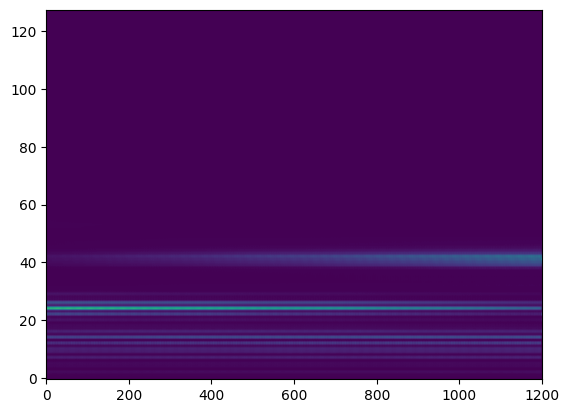

Playing audio for ALMTokenizer:


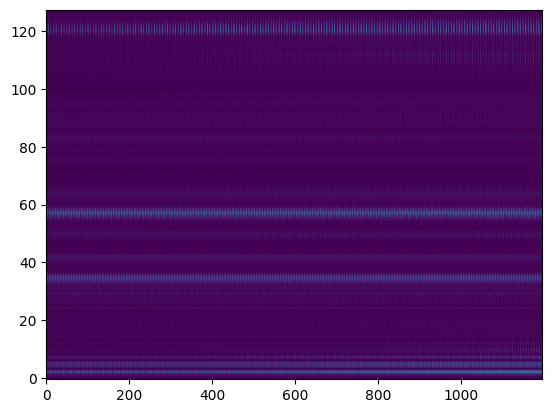

In [ ]:
from IPython.display import Audio, display
from torchaudio.transforms import MelSpectrogram

mel_transform = MelSpectrogram()

for method, audio in audios.items():
    print(f"Playing audio for {method}:")
    display(Audio(audio, autoplay=True, rate=24000))
    spec = mel_transform(torch.tensor(audio))
    spec = spec.squeeze(1)
    plt.imshow(spec.detach().cpu(), aspect='auto', origin='lower')
    plt.show()

# Timbre Transfer

In [ ]:
def align_centroid(starts, dest):
    """
    Translate all starting vectors so their centroid equals dest.

    Args:
        starts (array-like, shape (M, D)): Starting vectors.
        dest   (array-like, shape (D,)):   Destination vector.

    Returns:
        np.ndarray, shape (M, D): Translated vectors whose centroid == dest.
    """

    delta = dest - starts.mean(axis=0)      # direction+amount to move the centroid
    return starts + delta  

def align_centroid_torch(starts, dest):
    X = starts.to(dtype=torch.float32)           # (M, D)
    d = dest.to(X.device, dtype=torch.float32)             # (D,)
    delta = d - X.mean(dim=(0, 1))                    # (D,)
    return X + delta                             # (M, D)


def timbre_transfer(wav_path, move_to, X, df):
    waveform, sr = torchaudio.load(wav_path, normalize=True)
    waveform = torchaudio.functional.resample(
                    waveform, orig_freq=sr, new_freq=24000
                )

    wav_tensor = torch.tensor(waveform, dtype=torch.float32).mean(dim=0, keepdim=True)[None, :].to(device)

    with torch.no_grad():
        # EnCodec
        encodec = EncodecModel.encodec_model_24khz().eval().to(device)
        encoder = encodec.encoder.to(device)
        decoder = encodec.decoder.to(device)

        frames = encoder(wav_tensor.to(device)).permute(0, 2, 1)
        destination = create_vectors(move_to, df.loc["EnCodec"], X.loc["EnCodec"])
        destination = torch.tensor(destination[0])
        new_frames = align_centroid_torch(frames, destination)
        decoder_input = new_frames.permute(0, 2, 1)
        decoder_output = decoder(decoder_input)
        wav = decoder_output.flatten().cpu().detach().numpy()
        display(Audio(encodec(wav_tensor).flatten().cpu().detach().numpy(), rate=24000)) 
        display(Audio(wav, rate=24000))

        # ALMTokenizer
        frames = model.encode(wav_tensor.to(model.device))
        destination = create_vectors(move_to, df.loc["ALMTokenizer"], X.loc["ALMTokenizer"])
        destination = torch.tensor(destination[0])
        new_frames = align_centroid_torch(frames, destination)
        decoder_input = new_frames
        decoder_output = model.decode(decoder_input)
        wav = decoder_output.flatten().cpu().detach().numpy()
        display(Audio(model(wav_tensor.to(model.device))["x_hat"].flatten().cpu().detach().numpy(), rate=24000)) 
        display(Audio(wav, rate=24000))  


move_to = {
    "instrument": ["flute"],
    #"note": ["A"],
    "octave": ["5"],
    # "klass": ["good"]
    }

timbre_transfer(os.path.join("audio", "speech-male.wav"), move_to, X, df)

import os
import torchaudio

wav_path = os.path.join("audio", "speech-female.wav")
waveform, sr = torchaudio.load(wav_path, normalize=True)
waveform = torchaudio.functional.resample(
                waveform, orig_freq=sr, new_freq=24000
            )

wav_tensor = torch.tensor(waveform, dtype=torch.float32).mean(dim=0, keepdim=True)[None, :].to(device)

from IPython.display import Audio, display
device = "cpu"

with torch.no_grad():
    # EnCodec
    encodec = EncodecModel.encodec_model_24khz().eval().to(device)
    encoder = encodec.encoder.to(device)
    decoder = encodec.decoder.to(device)

    frames = encoder(wav_tensor.to(device)).permute(0, 2, 1)
    destination = create_vectors(move_to, df.loc["EnCodec"], X.loc["EnCodec"])
    destination = torch.tensor(destination[0])
    new_frames = align_centroid_torch(frames, destination)
    decoder_input = new_frames.permute(0, 2, 1)
    decoder_output = decoder(decoder_input)
    wav = decoder_output.flatten().cpu().detach().numpy()
    display(Audio(encodec(wav_tensor).flatten().cpu().detach().numpy(), rate=24000)) 
    display(Audio(wav, rate=24000))

    # ALMTokenizer
    frames = model.encode(wav_tensor.to(model.device))
    destination = create_vectors(move_to, df.loc["ALMTokenizer"], X.loc["ALMTokenizer"])
    destination = torch.tensor(destination[0])
    new_frames = align_centroid_torch(frames, destination)
    decoder_input = new_frames
    decoder_output = model.decode(decoder_input)
    wav = decoder_output.flatten().cpu().detach().numpy()
    display(Audio(model(wav_tensor.to(model.device))["x_hat"].flatten().cpu().detach().numpy(), rate=24000)) 
    display(Audio(wav, rate=24000))  

/tmp/ipykernel_350380/3562752126.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wav_tensor = torch.tensor(waveform, dtype=torch.float32).mean(dim=0, keepdim=True)[None, :].to(device)
/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_350380/3562752126.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  destination = torch.tensor(destination[0])


/tmp/ipykernel_350380/3562752126.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  destination = torch.tensor(destination[0])


/tmp/ipykernel_350380/3562752126.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wav_tensor = torch.tensor(waveform, dtype=torch.float32).mean(dim=0, keepdim=True)[None, :].to(device)
/tmp/ipykernel_350380/3562752126.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  destination = torch.tensor(destination[0])


/tmp/ipykernel_350380/3562752126.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  destination = torch.tensor(destination[0])


In [ ]:
new_frames.squeeze()

tensor([[ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534],
        [ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534],
        [ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534],
        ...,
        [ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534],
        [ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534],
        [ 0.9489, 11.5905, -3.4266,  ..., -0.7460, -1.0224,  1.8534]])

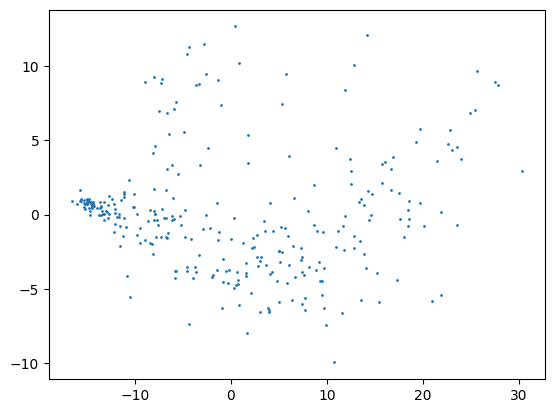

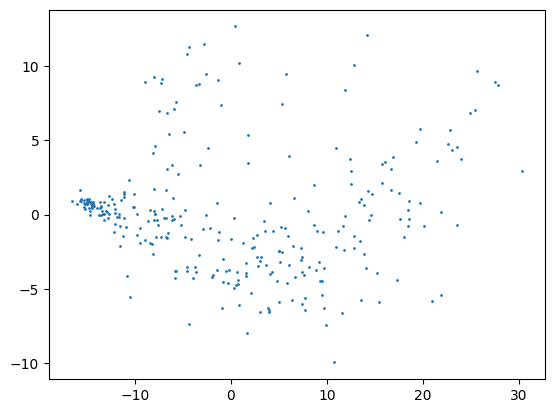

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
coords = pca.fit_transform(new_frames.squeeze())
plt.scatter(coords[:, 0], coords[:, 1], s=1)
plt.show()
pca = PCA()
coords = pca.fit_transform(frames.squeeze())
plt.scatter(coords[:, 0], coords[:, 1], s=1)